In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 
%config InlineBackend.figure_format = 'retina' 

sns.set_style(style='white')
sns.set_context(context ='paper')

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name()
rc('font', family=font_name)

font_path = 'font/NanumSquareRoundR.ttf'
fontprop = font_manager.FontProperties(fname=font_path)

pd.set_option('display.max_columns',999)

In [3]:
product = pd.read_csv('data/Product.csv')
search1 = pd.read_csv('data/Search1.csv')
search2 = pd.read_csv('data/Search2.csv')
session = pd.read_csv('data/Session.csv')
master = pd.read_csv('data/Master.csv')
custom = pd.read_csv('data/Custom.csv')

C:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 1. 데이터 전처리, 클렌징

In [3]:
len(product)

5024906

In [4]:
# product 이상치 제거
product = product[lambda x : x.HITS_SEQ != 1]

In [5]:
# 똑같은 row 지우기
product.drop_duplicates(inplace = True)
session.drop_duplicates(inplace = True)
search1.drop_duplicates(inplace = True)
search2.drop_duplicates(inplace = True)
master.drop_duplicates(inplace = True)
custom.drop_duplicates(inplace = True)

In [6]:
len(product)

5019730

In [7]:
# int 로 만들기
def str_to_int(x):
    if type(x) == str:
        return int(''.join(x.split(',')))
    else: return x

product['PD_BUY_AM'] = product.PD_BUY_AM.map(str_to_int)
session['TOT_SESS_HR_V'] = session.TOT_SESS_HR_V.map(str_to_int)

def for_PD_BUY_CT(x):
    if type(x) == str:
        if ',' in x : 
            return int(''.join(x.split(',')))
        else : 
            return int(x)
    else : 
        return x
    
product.PD_BUY_CT = product.PD_BUY_CT.map(for_PD_BUY_CT)

# PD_BUY_TO 추가
product['PD_BUY_TO'] = product.PD_BUY_AM * product.PD_BUY_CT

# 2. 구매 데이터프레임 만들기

In [6]:
## data merge
merge_df1 = pd.merge(product, session, how = 'inner', on =['CLNT_ID','SESS_ID'])
merge_df1.dropna(inplace = True)

In [7]:
mean_df = merge_df1.groupby(['CLNT_ID','SESS_ID','SESS_DT'])['HITS_SEQ','SESS_SEQ','TOT_PAG_VIEW_CT','TOT_SESS_HR_V'].mean().reset_index()

In [8]:
sum_df = pd.DataFrame(merge_df1.groupby(['CLNT_ID','SESS_ID','SESS_DT'])['PD_BUY_TO'].sum()).reset_index()

In [9]:
final_df = pd.merge(mean_df, sum_df, how = 'inner', on = ['CLNT_ID','SESS_ID','SESS_DT'])

In [10]:
final_df.head(1)

,CLNT_ID,SESS_ID,SESS_DT,HITS_SEQ,SESS_SEQ,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,PD_BUY_TO
0,8,6964877,20180606,40.0,7.0,38.0,366.0,38000


In [11]:
session_temp = session[['CLNT_ID','SESS_ID','SESS_DT','DVC_CTG_NM','ZON_NM']]

In [12]:
final_df = pd.merge(final_df, session_temp, how = 'left', on = ['CLNT_ID','SESS_ID','SESS_DT'])

In [13]:
final_df = pd.merge(final_df, custom, how = 'left')

In [14]:
final_df.head(1)

,CLNT_ID,SESS_ID,SESS_DT,HITS_SEQ,SESS_SEQ,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,PD_BUY_TO,DVC_CTG_NM,ZON_NM,CLNT_GENDER,CLNT_AGE
0,8,6964877,20180606,40.0,7.0,38.0,366.0,38000,mobile,Gyeonggi-do,M,20.0


In [16]:
final_df.to_csv('final_df_na.csv', index = False)

# 3. 소비별 상품군 구매여부 DF 만들기

In [95]:
temp_product = product[['CLNT_ID','SESS_ID','PD_C']]
temp_product.drop_duplicates(inplace = True)

temp_merge = pd.merge(temp_product, master[['PD_C','CLAC1_NM']], how = 'left')
temp_merge = temp_merge[['CLNT_ID','SESS_ID','CLAC1_NM']]
temp_merge.drop_duplicates(inplace = True)

temp_count = temp_merge.groupby(['CLNT_ID','SESS_ID']).count().reset_index()

In [96]:
product_dummydf = pd.get_dummies(temp_merge, prefix = 'CLAC1_NM').groupby(['CLNT_ID','SESS_ID']).sum().reset_index()

In [97]:
product_dummydf.head(1)

,CLNT_ID,SESS_ID,CLAC1_NM_가구,CLAC1_NM_건강식품,CLAC1_NM_계절가전,CLAC1_NM_과일,CLAC1_NM_구기/필드스포츠,CLAC1_NM_남성의류,CLAC1_NM_냉동식품,CLAC1_NM_냉장/세탁가전,CLAC1_NM_냉장식품,CLAC1_NM_모바일,CLAC1_NM_문구/사무용품,CLAC1_NM_상품권,CLAC1_NM_생활/주방가전,CLAC1_NM_세제/위생,CLAC1_NM_속옷/양말/홈웨어,CLAC1_NM_스포츠패션,CLAC1_NM_시즌스포츠,CLAC1_NM_식기/조리기구,CLAC1_NM_아웃도어/레저,CLAC1_NM_여성의류,CLAC1_NM_영상/음향가전,CLAC1_NM_완구,CLAC1_NM_원예/애완,CLAC1_NM_유아동의류,CLAC1_NM_음료,CLAC1_NM_인테리어/조명,CLAC1_NM_자동차용품,CLAC1_NM_주방잡화,CLAC1_NM_청소/세탁/욕실용품,CLAC1_NM_축산물,CLAC1_NM_출산/육아용품,CLAC1_NM_침구/수예,CLAC1_NM_컴퓨터,CLAC1_NM_패션잡화,CLAC1_NM_퍼스널케어,CLAC1_NM_헬스/피트니스,CLAC1_NM_화장품/뷰티케어
0,8,6964877,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [98]:
product_dummydf.to_csv('data/product_dummydf.csv', index = False)

# 4. 모델링을 위한 EDA / FE / FS, 데이터프레임 만들기
- NA 값 예측 모델링 -> NA 예측 -> 선호지수 모델링, time series 예측 모델링

## 4-1 NA 값 예측 모델링

In [3]:
# 구매데이터
final_df_na = pd.read_csv('data/final_df_na.csv')
final_df_na.head(1)

,CLNT_ID,SESS_ID,SESS_DT,HITS_SEQ,SESS_SEQ,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,PD_BUY_TO,DVC_CTG_NM,ZON_NM,CLNT_GENDER,CLNT_AGE
0,8,6964877,20180606,40.0,7.0,38.0,366.0,38000,mobile,Gyeonggi-do,M,20.0


In [11]:
final_df_na.columns

Index(['CLNT_ID', 'SESS_ID', 'SESS_DT', 'HITS_SEQ', 'SESS_SEQ',
       'TOT_PAG_VIEW_CT', 'TOT_SESS_HR_V', 'PD_BUY_TO', 'DVC_CTG_NM', 'ZON_NM',
       'CLNT_GENDER', 'CLNT_AGE'],
      dtype='object')

In [62]:
# 예측해야할 NA 값 비율
round ( final_df_na.isnull().sum() / len(final_df_na) ,2)

CLNT_ID            0.00
SESS_ID            0.00
SESS_DT            0.00
HITS_SEQ           0.00
SESS_SEQ           0.00
TOT_PAG_VIEW_CT    0.00
TOT_SESS_HR_V      0.00
PD_BUY_TO          0.00
DVC_CTG_NM         0.00
ZON_NM             0.00
CLNT_GENDER        0.18
CLNT_AGE           0.18
dtype: float64

- gender : 현재 여 90%, 남 10% 의 상황

C:\anaconda\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['NanumSquareRound'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


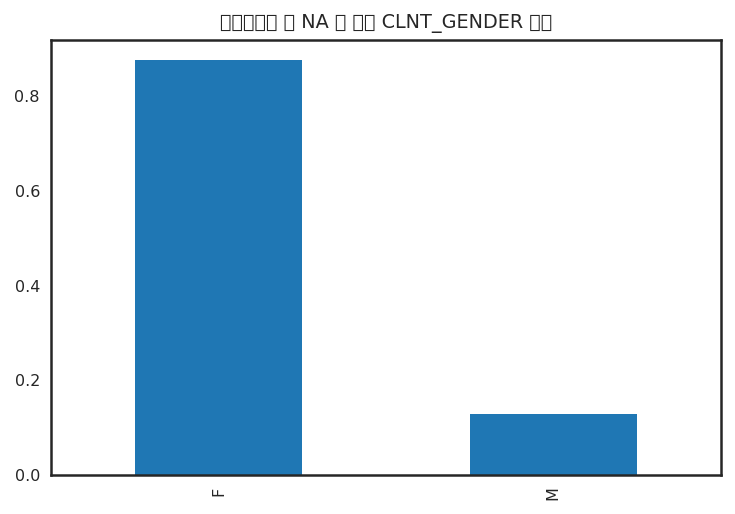

In [4]:
( final_df_na.CLNT_GENDER.value_counts() / final_df_na.CLNT_GENDER.value_counts().sum() ) .plot.bar()
plt.title('구매데이터 중 NA 값 제외 CLNT_GENDER 비율')
plt.show()

- age : 30, 40대가 80%  나머지가 20%

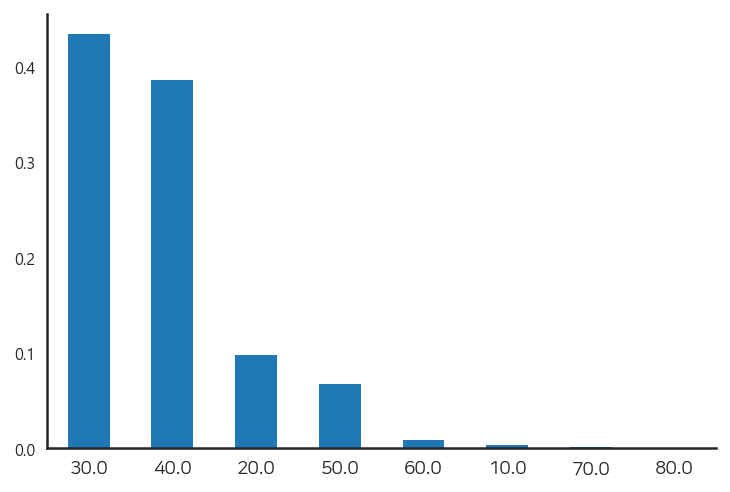

In [23]:
( final_df_na.CLNT_AGE.value_counts() / final_df_na.CLNT_AGE.value_counts().sum() ) .plot.bar()
# plt.title('구매데이터 중 NA 값 제외 CLNT_AGE 비율')
sns.despine()
plt.xticks(rotation = 360, fontproperties = fontprop)
plt.show()

In [24]:
# 30,40대에 너무 모여 있어서 나머지는 합치기로
def for_CLNT_AGE(x):
    if x in [50.0,60.0,70.0,80.0]: return 'old'
    elif  x in [20.0,10.0] : return 'young'
    else : return x
    
final_df_na.CLNT_AGE = final_df_na.CLNT_AGE.map(for_CLNT_AGE)

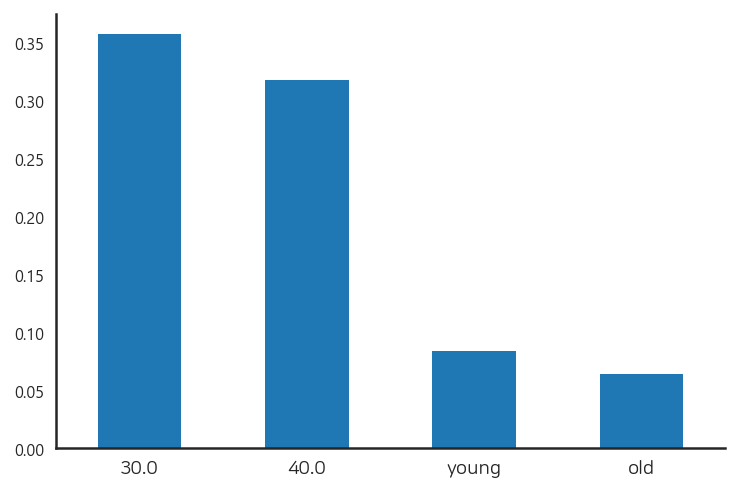

In [25]:
(final_df_na.CLNT_AGE.value_counts() / len(final_df_na)).plot.bar()
# plt.title('구매데이터 중 NA 값 제외 CLNT_AGE 비율')
sns.despine()
plt.xticks(rotation = 360, fontproperties = fontprop)
plt.show()

### 변수 추가
- MONTH, DAY, WEEKDAY
- SEARCH_CNT  : 상품구매시 검색여부
- ONE_PAG_HR_V : 한 페이지를 얼마나 보고 있었는지 (TOT_SESS_HR_V	/ TOT_PAG_VIEW_CT)

- MONTH, DAY, WEEKDAY

In [26]:
# 날짜 컬럼
def month(x):
    return str(x)[4:6]
def day(x):
    return str(x)[6:]

import datetime

def weekday(x):
    dt = datetime.datetime(int(str(x)[:4]), int(str(x)[4:6]) , int(str(x)[6:]))
    return dt.weekday()

final_df_na['MONTH'] = final_df_na.SESS_DT.map(month)
final_df_na['DAY'] = final_df_na.SESS_DT.map(day)
final_df_na['WEEKDAY'] = final_df_na.SESS_DT.map(weekday)

- SEARCH_CNT

In [50]:
# SEARCH_CNT 변수 추가
search_cnt = pd.DataFrame(search1.groupby(['CLNT_ID','SESS_ID'])['SEARCH_CNT'].sum()).reset_index()
final_df_na = pd.merge(final_df_na, search_cnt, how = 'left', on = ['CLNT_ID','SESS_ID'])
final_df_na['SEARCH_CNT'].fillna(0, inplace = True)

# 카테고리화
def search(x):
    if x == 0: return 0
    else : return 1

final_df_na.SEARCH_CNT = final_df_na.SEARCH_CNT.map(search) 

In [105]:
final_df_na.groupby('CLNT_GENDER')['SEARCH_CNT'].mean()
# 여자가 조금 더 많이 하는 경향

CLNT_GENDER
F    0.456727
M    0.415501
Name: SEARCH_CNT, dtype: float64

In [106]:
final_df_na.groupby('CLNT_AGE')['SEARCH_CNT'].mean()
# 나이가 들수록 더 적게하는 경향

CLNT_AGE
10.0    0.475879
20.0    0.425855
30.0    0.449169
40.0    0.467579
50.0    0.415849
60.0    0.417594
70.0    0.423923
80.0    0.286364
Name: SEARCH_CNT, dtype: float64

- ONE_PAG_HR_V 

In [12]:
# ONE_PAG_HR_V 변수 추가
final_df_na['ONE_PAG_HR_V'] = final_df_na.TOT_SESS_HR_V / final_df_na.TOT_PAG_VIEW_CT

In [104]:
final_df_na.groupby('CLNT_GENDER')['ONE_PAG_HR_V'].mean()
# 남자가 미세하게 높음

CLNT_GENDER
F    16.990209
M    17.390554
Name: ONE_PAG_HR_V, dtype: float64

In [103]:
final_df_na.groupby('CLNT_AGE')['ONE_PAG_HR_V'].mean()
# 나이가 들수록 시간이 길어지는 경향

CLNT_AGE
10.0    17.985013
20.0    16.263884
30.0    16.709263
40.0    17.295359
50.0    18.455220
60.0    19.215005
70.0    19.098976
80.0    20.941990
Name: ONE_PAG_HR_V, dtype: float64

In [5]:
# numeric columns
n_col = ['HITS_SEQ', 'SESS_SEQ','TOT_PAG_VIEW_CT', 'TOT_SESS_HR_V', 'PD_BUY_TO','ONE_PAG_HR_V']
# categoric columns
c_col = ['DVC_CTG_NM', 'ZON_NM','CLNT_GENDER', 'CLNT_AGE', 'SEARCH_CNT', 'MONTH','DAY','WEEKDAY']

### numeric variable analysis

- correlation

In [29]:
final_df_na1 = final_df_na.copy()

In [15]:
print('numeric variable :' ,n_col)

numeric variable : ['HITS_SEQ', 'SESS_SEQ', 'TOT_PAG_VIEW_CT', 'TOT_SESS_HR_V', 'PD_BUY_TO', 'ONE_PAG_HR_V']


In [16]:
final_df_na1[n_col].corr()
# HITS_SEQ 와 TOT_PAG_VIEW_CT
# TOT_SESS_HR_V 와 TOT_PAG_VIEW_CT
# 두 개의 묶음이 가장 높다
# TOT_PAG_VIEW_CT을 지우도록 한다

,HITS_SEQ,SESS_SEQ,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,PD_BUY_TO,ONE_PAG_HR_V
HITS_SEQ,1.000000,0.092533,0.874471,0.604802,0.050179,-0.179028
SESS_SEQ,0.092533,1.000000,0.156559,0.060961,-0.037359,-0.112020
TOT_PAG_VIEW_CT,0.874471,0.156559,1.000000,0.680278,0.073343,-0.197959
TOT_SESS_HR_V,0.604802,0.060961,0.680278,1.000000,0.087916,0.279153
PD_BUY_TO,0.050179,-0.037359,0.073343,0.087916,1.000000,0.035976
ONE_PAG_HR_V,-0.179028,-0.112020,-0.197959,0.279153,0.035976,1.000000


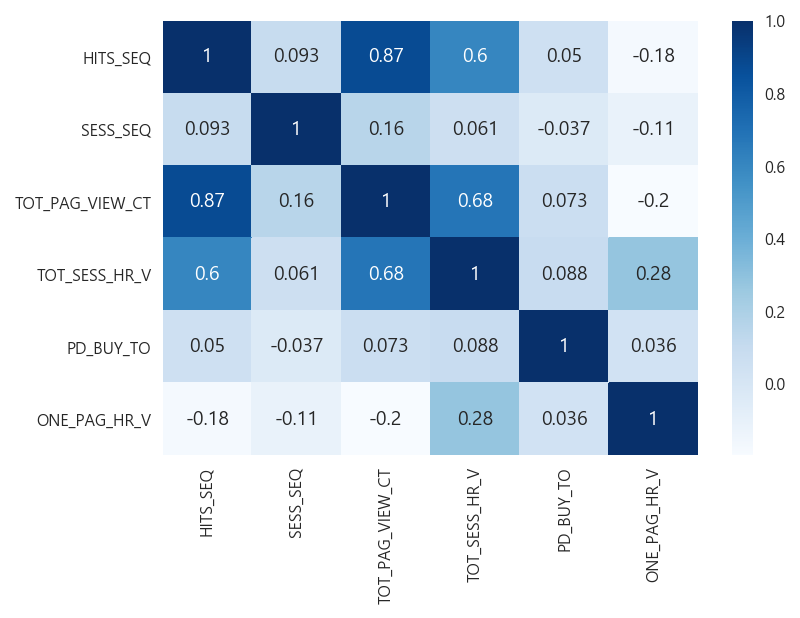

In [20]:
sns.heatmap(final_df_na1[n_col].corr(), annot = True, cmap = 'Blues')

In [55]:
final_df_na1.drop('TOT_PAG_VIEW_CT', axis = 1, inplace  =True)

n_col = ['HITS_SEQ',
 'SESS_SEQ',
 'TOT_SESS_HR_V',
 'PD_BUY_TO',
 'ONE_PAG_HR_V']

- outlier

In [54]:
for i in n_col:
    IQR = final_df_na1[i].quantile(0.75) - final_df_na[i].quantile(0.25)
    cut_up = final_df_na1[i].quantile(0.75) + 5*IQR
    cut_down = final_df_na1[i].quantile(0.25) - 5*IQR
    print(i,':',( (final_df_na1[i] < cut_down).sum() + (final_df_na1[i] > cut_up).sum() )/ len(final_df_na) )

HITS_SEQ : 0.006873108310310515
SESS_SEQ : 0.016606458845878358
TOT_SESS_HR_V : 0.0019511931084289465
PD_BUY_TO : 0.022011074679942046
ONE_PAG_HR_V : 0.012090501548942582


모델링을 위해 전체데이터 중 5% 정도로 이상치를 지우도록 해보자.

In [56]:
temp_df = final_df_na1.copy()

In [57]:
cut_up = list()
cut_down = list()

for i in n_col:
    IQR = final_df_na1[i].quantile(0.75) - final_df_na1[i].quantile(0.25)
    cut_up.append(final_df_na1[i].quantile(0.75) + 5*IQR)
    cut_down.append(final_df_na1[i].quantile(0.25) - 5*IQR)

for i in range(len(cut_up)):
    final_df_na1 = final_df_na1[lambda x : x[n_col[i]] < cut_up[i]]
    final_df_na1 = final_df_na1[lambda x : x[n_col[i]] > cut_down[i]]

In [58]:
print('전체 data 중 지워진 비율 : ', round((len(temp_df) -len(final_df_na1)) / len(temp_df),2) ) 

전체 data 중 지워진 비율 :  0.06


### categorical variable analysis

In [33]:
final_df_na2 = final_df_na1.copy()

In [60]:
print('categorical variable:', c_col)

categorical variable: ['DVC_CTG_NM', 'ZON_NM', 'CLNT_GENDER', 'CLNT_AGE', 'SEARCH_CNT', 'MONTH', 'DAY', 'WEEKDAY']


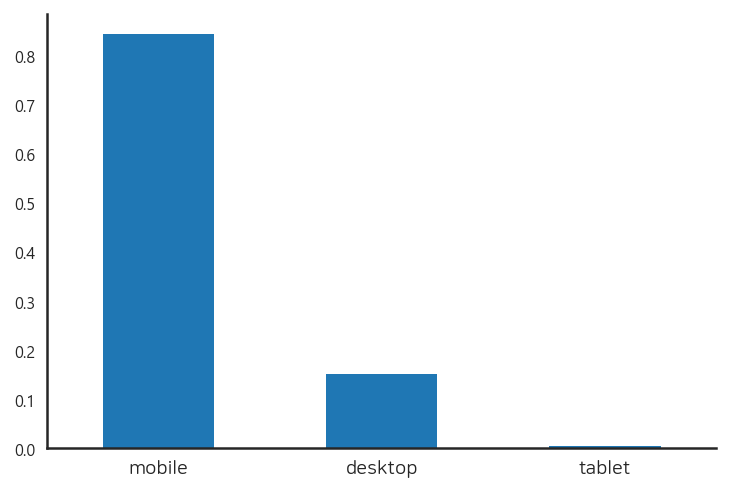

In [31]:
# 소비데이터 중 95% 가 mobile
(final_df_na2.DVC_CTG_NM.value_counts() / len(final_df_na2)).plot.bar()
# plt.title('DVC_CTG_NM 변수 label들의 비율')
sns.despine()
plt.xticks(rotation = 360, fontproperties = fontprop)
plt.show()

In [148]:
# gender
gendergroup = final_df_na2.groupby('CLNT_GENDER')['DVC_CTG_NM'].value_counts()/final_df_na2.groupby('CLNT_GENDER')['DVC_CTG_NM'].count()
gendergroup_df = pd.DataFrame(gendergroup)
gendergroup_df.columns = ['비율']
gendergroup_df.reset_index(inplace = True)
pd.concat([ gendergroup_df[lambda x : x.CLNT_GENDER == 'F'], gendergroup_df[lambda x : x.CLNT_GENDER == 'M'].reset_index(drop =True) ], axis = 1)

,CLNT_GENDER,DVC_CTG_NM,비율,CLNT_GENDER,DVC_CTG_NM,비율
0,F,mobile,0.995404,M,mobile,0.991385
1,F,tablet,0.004389,M,tablet,0.006937
2,F,desktop,0.000207,M,desktop,0.001678


In [151]:
# age
agegroup = final_df_na2.groupby('CLNT_AGE')['DVC_CTG_NM'].value_counts()/final_df_na2.groupby('CLNT_AGE')['DVC_CTG_NM'].count()
agegroup_df = pd.DataFrame(agegroup)
agegroup_df.columns = ['비율']
agegroup_df.reset_index(inplace = True)
age1 = pd.concat([ agegroup_df[lambda x : x.CLNT_AGE == 'old'].reset_index(drop =True), agegroup_df[lambda x : x.CLNT_AGE == 'young'].reset_index(drop =True) ], axis = 1)
age2 = pd.concat([ agegroup_df[lambda x : x.CLNT_AGE == 30.0].reset_index(drop =True), agegroup_df[lambda x : x.CLNT_AGE == 40.0].reset_index(drop =True) ], axis = 1)
pd.concat([age1, age2], axis = 1)

,CLNT_AGE,DVC_CTG_NM,비율,CLNT_AGE,DVC_CTG_NM,비율,CLNT_AGE,DVC_CTG_NM,비율,CLNT_AGE,DVC_CTG_NM,비율
0,old,mobile,0.98643,young,mobile,0.995987,30,mobile,0.997174,40,mobile,0.993710
1,old,tablet,0.01230,young,tablet,0.003642,30,tablet,0.002630,40,tablet,0.005845
2,old,desktop,0.00127,young,desktop,0.000371,30,desktop,0.000196,40,desktop,0.000445


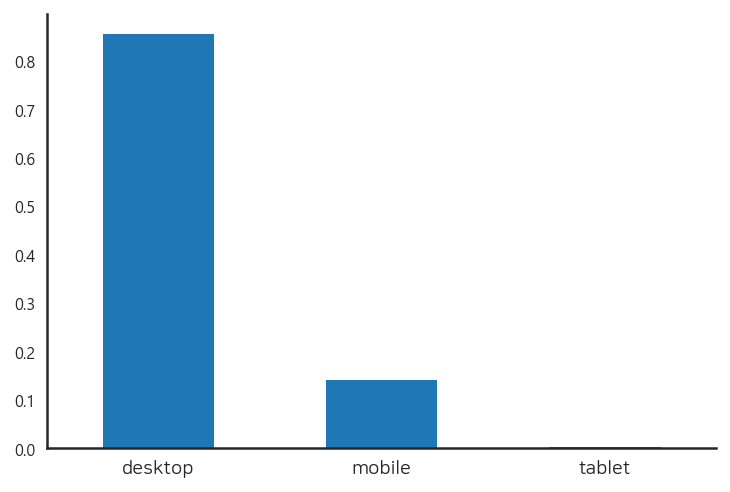

In [32]:
# NA 데이터들은 85% 가 desktop 
# 오히려 모델링에 방해될 수도
na = final_df_na2[final_df_na2.CLNT_GENDER.isnull()].DVC_CTG_NM.value_counts()
(na / na.sum()).plot.bar()
# plt.title('NA의 DVC_CTG_NM 변수 label들의 비율 ')
sns.despine()
plt.xticks(rotation = 360, fontproperties = fontprop)
plt.show()

In [61]:
# mobile, not_mobile 로 나누기
def for_DVC_CTG_NM(x):
    if x in ['desktop','tablet'] : return 'not_mobile'
    else : return x
    
    
final_df_na2.DVC_CTG_NM = final_df_na2.DVC_CTG_NM.map(for_DVC_CTG_NM)

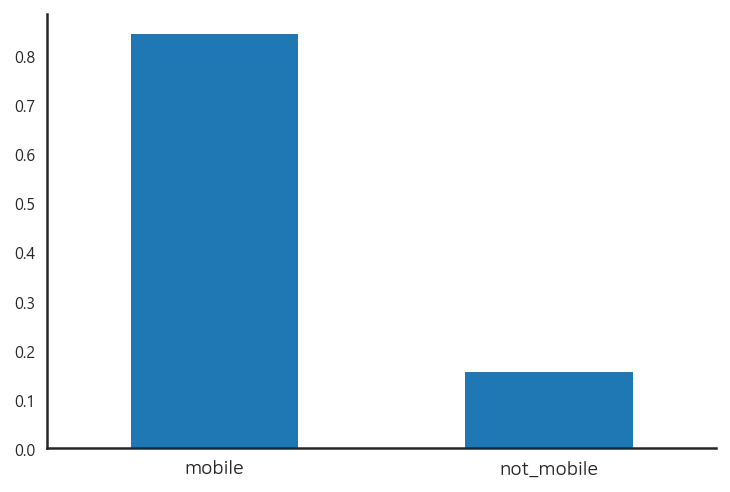

In [34]:
(final_df_na2.DVC_CTG_NM.value_counts() / len(final_df_na2)).plot.bar()
# plt.title('DVC_CTG_NM 변수 label들의 비율')
sns.despine()
plt.xticks(rotation = 360, fontproperties = fontprop)
plt.show()

- ZON_NM : 다소 high cardinality의 모습과 편향된 모습이 보이므로 label들을 묶어주는 FE 방법 선택

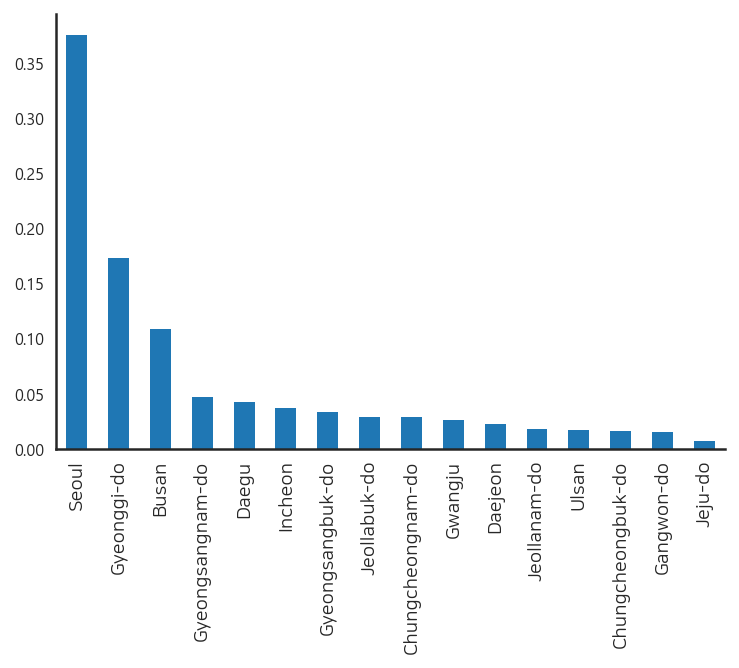

In [39]:
# plt.title('ZON_NM 변수 label들의 비율')
( final_df_na2.ZON_NM.value_counts() / len(final_df_na2) ).plot.bar()
sns.despine()
plt.xticks( fontproperties = fontprop)
plt.show()

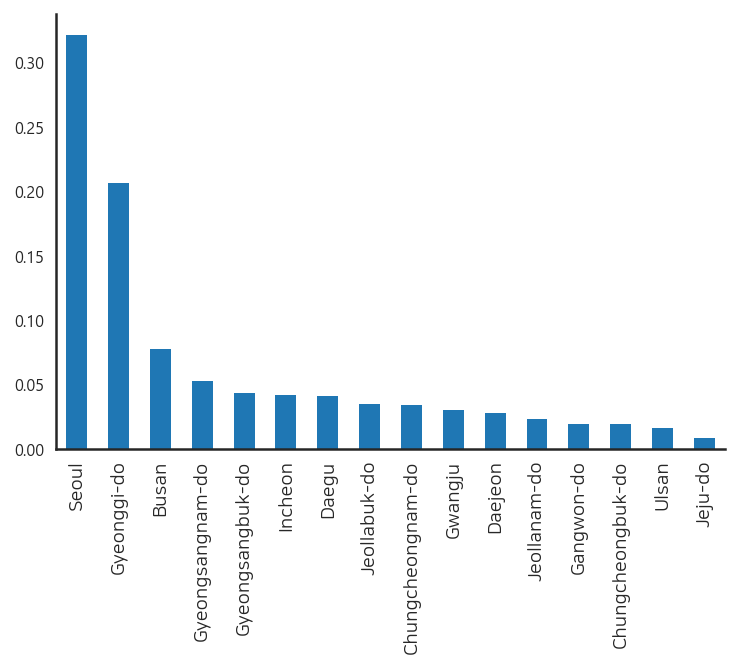

In [40]:
# NA 데이터들도 not NA 데이터들과 비슷한 모습
na = final_df_na2[final_df_na2.CLNT_GENDER.isnull()].ZON_NM.value_counts()
(na / na.sum()).plot.bar()
# plt.title('NA의 ZON_NM 변수 label들의 비율 ')
sns.despine()
plt.xticks(fontproperties = fontprop)
plt.show()

In [135]:
# gender 에 따른 별 차이는 없어보임
gendergroup = final_df_na2.groupby('CLNT_GENDER')['ZON_NM'].value_counts()/final_df_na2.groupby('CLNT_GENDER')['ZON_NM'].count()
gendergroup_df = pd.DataFrame(gendergroup)
gendergroup_df.columns = ['비율']
gendergroup_df.reset_index(inplace = True)
pd.concat([ gendergroup_df[lambda x : x.CLNT_GENDER == 'F'], gendergroup_df[lambda x : x.CLNT_GENDER == 'M'].reset_index(drop =True) ], axis = 1)

,CLNT_GENDER,ZON_NM,비율,CLNT_GENDER,ZON_NM,비율
0,F,Seoul,0.379937,M,Seoul,0.439497
1,F,Gyeonggi-do,0.170097,M,Gyeonggi-do,0.137754
2,F,Busan,0.114092,M,Busan,0.129816
3,F,Gyeongsangnam-do,0.047627,M,Daegu,0.043274
4,F,Daegu,0.043535,M,Gyeongsangnam-do,0.038026
5,F,Incheon,0.036828,M,Incheon,0.029163
6,F,Gyeongsangbuk-do,0.032059,M,Gyeongsangbuk-do,0.027579
7,F,Chungcheongnam-do,0.028178,M,Chungcheongnam-do,0.024487
8,F,Jeollabuk-do,0.028177,M,Jeollabuk-do,0.023193
9,F,Gwangju,0.025625,M,Gwangju,0.022361


In [152]:
# age
agegroup = final_df_na2.groupby('CLNT_AGE')['ZON_NM'].value_counts()/final_df_na2.groupby('CLNT_AGE')['ZON_NM'].count()
agegroup_df = pd.DataFrame(agegroup)
agegroup_df.columns = ['비율']
agegroup_df.reset_index(inplace = True)
age1 = pd.concat([ agegroup_df[lambda x : x.CLNT_AGE == 'old'].reset_index(drop =True), agegroup_df[lambda x : x.CLNT_AGE == 'young'].reset_index(drop =True) ], axis = 1)
age2 = pd.concat([ agegroup_df[lambda x : x.CLNT_AGE == 30.0].reset_index(drop =True), agegroup_df[lambda x : x.CLNT_AGE == 40.0].reset_index(drop =True) ], axis = 1)
pd.concat([age1, age2], axis = 1)

,CLNT_AGE,ZON_NM,비율,CLNT_AGE,ZON_NM,비율,CLNT_AGE,ZON_NM,비율,CLNT_AGE,ZON_NM,비율
0,old,Seoul,0.384784,young,Seoul,0.498069,30,Seoul,0.392647,40,Seoul,0.352167
1,old,Gyeonggi-do,0.195857,young,Gyeonggi-do,0.129494,30,Gyeonggi-do,0.156956,40,Gyeonggi-do,0.180234
2,old,Busan,0.110906,young,Busan,0.099687,30,Busan,0.119454,40,Busan,0.117679
3,old,Incheon,0.039908,young,Daegu,0.037388,30,Gyeongsangnam-do,0.047952,40,Gyeongsangnam-do,0.049466
4,old,Daegu,0.039038,young,Gyeongsangnam-do,0.034461,30,Daegu,0.042294,40,Daegu,0.047425
5,old,Gyeongsangnam-do,0.038600,young,Incheon,0.030128,30,Incheon,0.034117,40,Incheon,0.038588
6,old,Gyeongsangbuk-do,0.031436,young,Gyeongsangbuk-do,0.023541,30,Chungcheongnam-do,0.030955,40,Gyeongsangbuk-do,0.034281
7,old,Jeollabuk-do,0.025764,young,Jeollabuk-do,0.022702,30,Gyeongsangbuk-do,0.030946,40,Jeollabuk-do,0.028692
8,old,Gwangju,0.024926,young,Chungcheongnam-do,0.021800,30,Jeollabuk-do,0.028009,40,Gwangju,0.028320
9,old,Chungcheongnam-do,0.020259,young,Gwangju,0.021333,30,Gwangju,0.023458,40,Chungcheongnam-do,0.027111


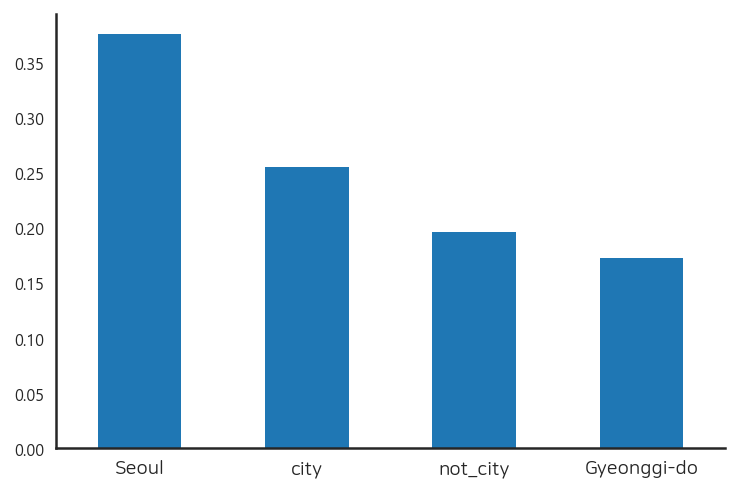

In [62]:
# 다른 변수와의 관계를 살펴봤는데 유의미한 결과 발견 불가
# 서울 / 도 / 광역시
# 도시화가 진행될수록 소비금액, 나이, 소비종류에 있어서 미세한 차이가 있을거라 예상

def for_ZON_NM(x):
    if x in ['Busan', 'Incheon', 'Daejeon', 'Daegu', 'Ulsan','Gwangju'] : return 'city'
    elif x in ['Gyeongsangbuk-do', 'Gyeongsangnam-do','Chungcheongbuk-do', 'Chungcheongnam-do',
               'Jeollabuk-do', 'Jeollanam-do','Jeju-do','Gangwon-do'] :  return 'not_city'
    else : return x 
    
final_df_na2.ZON_NM = final_df_na2.ZON_NM.map(for_ZON_NM)

( final_df_na2.ZON_NM.value_counts() / len(final_df_na2)).plot.bar()
# plt.title('ZON_NM 변수 label들의 비율 ')
sns.despine()
plt.xticks(rotation = 360, fontproperties = fontprop)
plt.show()

- DAY : 예측에 도움이 될지는 모르겠지만 high cardinality의 문제가 있기 때문에 묶는다

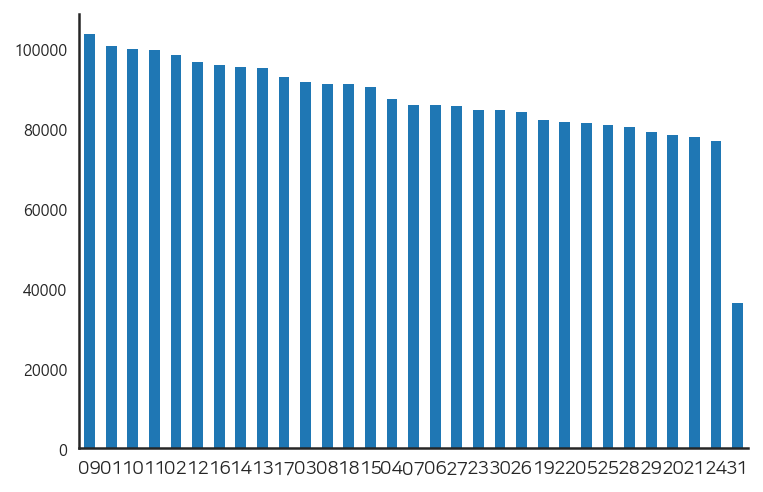

In [34]:
final_df_na2.DAY.value_counts().plot.bar()
sns.despine()
plt.xticks(rotation = 360, fontproperties = fontprop)
plt.show()

In [31]:
def for_DAY(x):
    if x < 11 : return 'first'
    elif (x >= 11 and x < 21): return 'second'
    else : return 'third'

final_df_na2.DAY = final_df_na2.DAY.map(int)
final_df_na2.DAY = final_df_na2.DAY.map(for_DAY)

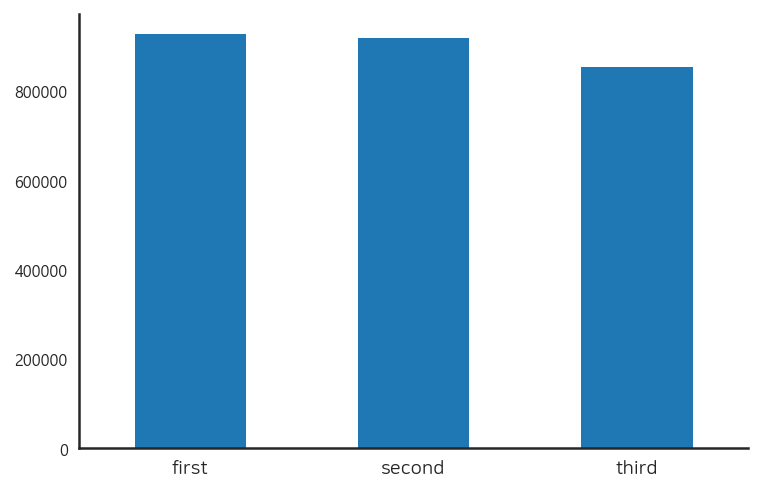

In [32]:
final_df_na2.DAY.value_counts().plot.bar()
sns.despine()
plt.xticks(rotation = 360, fontproperties = fontprop)
plt.show()

In [64]:
# MONTH
final_df_na2.MONTH = final_df_na2.MONTH.map(int)

###  Numeric variable 정규분포화, categoric variable 더미화

In [65]:
fillna_df = final_df_na2.copy()

In [66]:
not_na_df = fillna_df.dropna().reset_index(drop = True)
na_df = fillna_df[fillna_df.CLNT_GENDER.isnull()].reset_index(drop = True)

In [67]:
train_df = fillna_df.dropna().reset_index(drop = True)
test_df = fillna_df[fillna_df.CLNT_GENDER.isnull()].reset_index(drop = True)

- boxcox 알고리즘

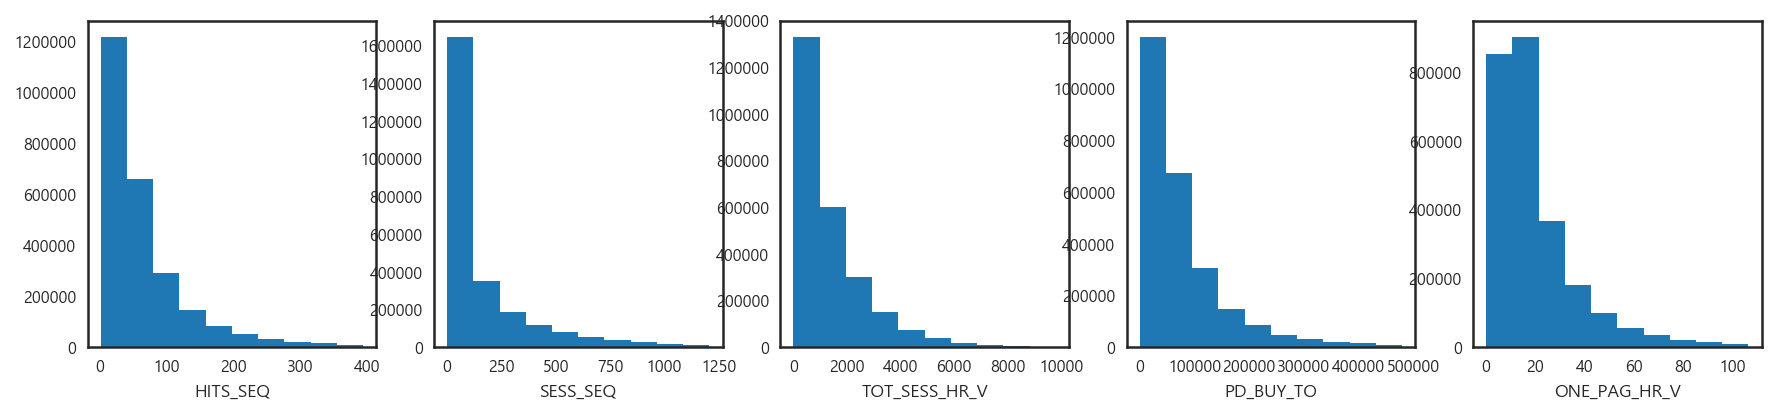

In [68]:
fig, axes = plt.subplots(1, len(n_col),figsize = (15,3))
for i in range(len(n_col)):
    axes[i].hist(fillna_df[n_col[i]])
    axes[i].set_xlabel(n_col[i])

In [69]:
import scipy.stats as stats

for i in n_col:
    train_df[i] = stats.boxcox(train_df[i])[0]
    
for i in n_col:
    test_df[i] = stats.boxcox(test_df[i])[0]

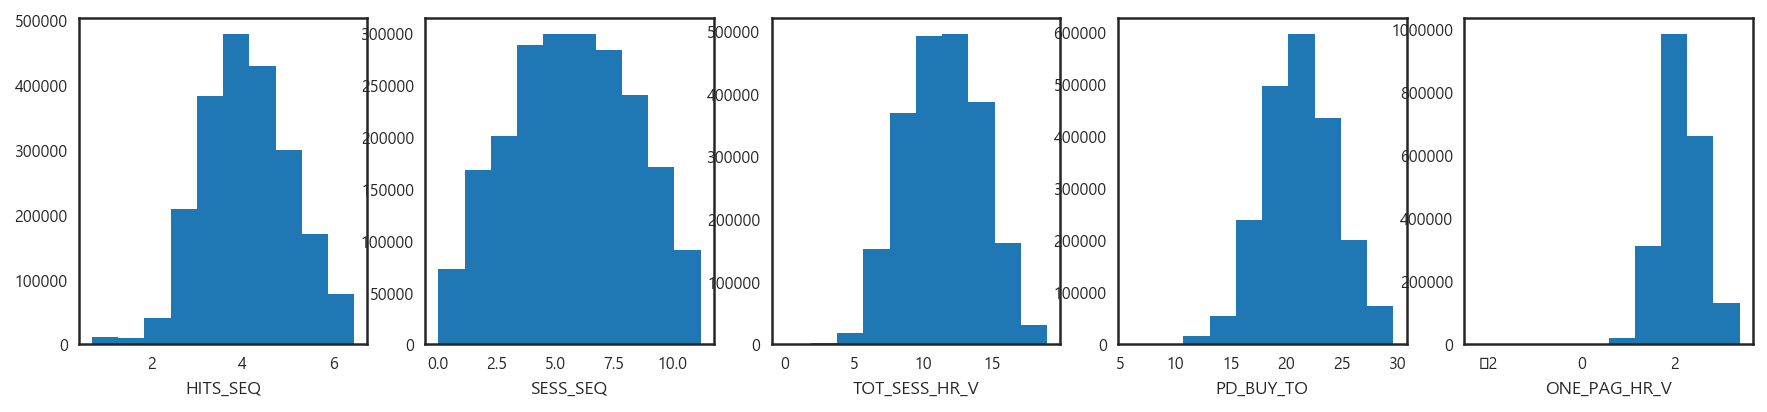

In [70]:
fig, axes = plt.subplots(1, len(n_col),figsize = (15,3))
for i in range(len(n_col)):
    axes[i].hist(train_df[n_col[i]])
    axes[i].set_xlabel(n_col[i])

- 더미화

In [71]:
DVC_CTG_NM_dict = {k:i for i, k in enumerate(train_df.DVC_CTG_NM.unique(), 0)}
ZON_NM_dict = {k:i for i, k in enumerate(train_df.ZON_NM.unique(), 0)}
CLNT_GENDER_dict = {k:i for i, k in enumerate(train_df.CLNT_GENDER.unique(), 0)}
CLNT_AGE_dict = {k:i for i, k in enumerate(train_df.CLNT_AGE.unique(), 0)}
DAY_dict = {k:i for i, k in enumerate(train_df.DAY.unique(), 0)}

train_df.DVC_CTG_NM = train_df.DVC_CTG_NM.map(DVC_CTG_NM_dict)
train_df.ZON_NM = train_df.ZON_NM.map(ZON_NM_dict) 
train_df.CLNT_GENDER = train_df.CLNT_GENDER.map(CLNT_GENDER_dict) 
train_df.CLNT_AGE = train_df.CLNT_AGE.map(CLNT_AGE_dict) 
train_df.DAY = train_df.DAY.map(DAY_dict)

test_df.DVC_CTG_NM = test_df.DVC_CTG_NM.map(DVC_CTG_NM_dict)
test_df.ZON_NM = test_df.ZON_NM.map(ZON_NM_dict) 
test_df.DAY = test_df.DAY.map(DAY_dict)

### 상품군 구매 데이터 추가
- 너무 sparse 하고 변수의 수가 많아 PCA를 통해 차원축소하기로 결정
- 최종 변수 갯수는 37개에서 8개

In [72]:
# 상품군 구매 데이터
product_dummydf = pd.read_csv('data/product_dummydf.csv', encoding = 'euc-kr')

In [73]:
pca_df = product_dummydf.drop(['CLNT_ID', 'SESS_ID'], axis = 1)
pca_id = product_dummydf[['CLNT_ID', 'SESS_ID']]

In [74]:
# components 의 갯수는 gender 2 * age 4 = 8개
from sklearn.decomposition import PCA

X_pca = np.array(pca_df)
pca = PCA(n_components=8, random_state = 0)
pca.fit(X_pca)
pca_result = pca.transform(X_pca)

print('variance : ', pca.explained_variance_ratio_)
print('variance 합 : ', sum(pca.explained_variance_ratio_))

variance :  [0.13386583 0.13014018 0.1160242  0.09781802 0.07826719 0.05716686
 0.04954836 0.03351927]
variance 합 :  0.6963499139612885


In [75]:
pca_result_df = pd.DataFrame(pca_result, columns = ['pca1','pca2','pca3','pca4','pca5','pca6','pca7','pca8'])

In [76]:
product_buy = pd.concat([pca_id, pca_result_df], axis = 1)

In [77]:
train_df = pd.merge(train_df, product_buy, how = 'left', on = ['CLNT_ID','SESS_ID'])
test_df = pd.merge(test_df, product_buy, how = 'left', on = ['CLNT_ID','SESS_ID'])

In [78]:
train_df.head()

,CLNT_ID,SESS_ID,SESS_DT,HITS_SEQ,SESS_SEQ,TOT_SESS_HR_V,PD_BUY_TO,DVC_CTG_NM,ZON_NM,CLNT_GENDER,CLNT_AGE,MONTH,DAY,WEEKDAY,SEARCH_CNT,ONE_PAG_HR_V,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8
0,8,6964877,20180606,3.866404,2.192006,9.248459,20.106578,0,0,0,0,6,0,2,0,1.935502,-0.039979,0.082366,0.853637,0.271311,0.193870,0.043453,-0.002423,0.010233
1,8,7017688,20180605,4.547016,0.722806,9.827804,20.106578,0,1,0,0,6,0,1,0,1.845009,-0.039979,0.082366,0.853637,0.271311,0.193870,0.043453,-0.002423,0.010233
2,14,1156991,20180911,6.072351,1.775453,17.789226,22.147222,0,0,1,1,9,1,1,1,2.645942,-0.039979,0.082366,0.853637,0.271311,0.193870,0.043453,-0.002423,0.010233
3,32,759569,20180917,3.780905,6.234343,12.002059,18.067199,0,2,0,2,9,1,0,0,1.874271,-0.027294,0.001086,0.059112,-0.170289,-0.669826,0.691596,0.014597,-0.007453
4,32,1136737,20180911,4.516477,6.131823,14.803582,21.451906,0,2,0,2,9,1,1,0,2.798674,0.069695,0.061687,0.028139,-0.854651,0.388392,0.061367,0.004929,0.007470


In [79]:
col_for_predict = [ 'HITS_SEQ', 'SESS_SEQ', 'TOT_SESS_HR_V', 'PD_BUY_TO','ONE_PAG_HR_V', 'DVC_CTG_NM', 'ZON_NM', 'SEARCH_CNT','MONTH','DAY','WEEKDAY', 'pca1', 'pca2', 'pca3', 'pca4',
       'pca5', 'pca6', 'pca7', 'pca8']

### oversampling for predict CLNT_GENDER
SMOTE 를 활용한 oversampling 
- gender의 경우 전부 F 로 예측
- age의 경우 전부 30,40 대로 예측
- 따라서 oversampling을 통해 문제해결

In [80]:
# 시간이 오래걸리므로 random 추출 0.1
sam_df = train_df.sample(frac = 0.1, random_state = 0)

from imblearn.over_sampling import SMOTE

X = sam_df[col_for_predict]
y_gender = sam_df.CLNT_GENDER
y_age = sam_df.CLNT_AGE

In [ ]:
X_gender, y_gender = SMOTE(random_state = 0).fit_resample(X, y_gender)

In [ ]:
X_age, y_age = SMOTE(random_state = 0).fit_resample(X, y_age)

BayesSearchCV와 Random Foreset 를 활용한 분류 예측 모델링(score는 f1score)
1. gender

In [118]:
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
scorer = make_scorer(f1_score)

In [120]:
import warnings
warnings.filterwarnings('ignore')

from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# we're using a logistic regression model
clf_gender = RandomForestClassifier(random_state=0, verbose=0)

# this is our parameter grid
param_grid = {
    'n_estimators': (50,100,200),  
    'max_depth': (None, 7, 5),
    'criterion' : ['gini', 'entropy'],
    'max_features' : ['auto', 'log2']
}

# set up our optimiser to find the best params in 30 searches
opt_gender = BayesSearchCV(
    clf_gender,
    param_grid,
    n_iter=9,
    random_state=0,
    scoring = scorer,
    verbose=0,
    cv = 3
)

In [121]:
opt_gender.fit(X_gender, y_gender)

BayesSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_iter=9, n_jobs=1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=0,
       refit=True, return_train_score=False, scoring=make_scorer(f1_score),
       search_spaces={'n_estimators': (50, 100, 200), 'max_depth': (None, 7, 5), 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'log2']},
       verbose=0)

In [122]:
print("Best Score : {}".format(opt_gender.best_score_))
print("Best Params : {}".format(opt_gender.best_params_))

Best Score : 0.9269467587566824
Best Params : {'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 50}


In [123]:
RF1 = RandomForestClassifier(**opt_gender.best_params_)
RF1.fit(X_gender, y_gender)

from sklearn.externals import joblib
joblib.dump(RF1, 'best_RF1_model.pkl')

['best_RF1_model.pkl']

In [125]:
clnt_gender = RF1.predict(test_df[col_for_predict])

In [126]:
import collections
collections.Counter(clnt_gender)

Counter({0: 42544, 1: 388155})

2.age

In [127]:
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
scorer2 = make_scorer(f1_score,average = 'micro')

In [131]:
import warnings
warnings.filterwarnings('ignore')

from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# we're using a logistic regression model
clf_age = RandomForestClassifier(random_state=0, verbose=0)

# this is our parameter grid
param_grid = {
    'n_estimators': (50,100,200),  
    'max_depth': (None, 7, 5),
    'criterion' : ['gini', 'entropy']
}

# set up our optimiser to find the best params in 30 searches
opt_age = BayesSearchCV(
    clf_age,
    param_grid,
    n_iter=9,
    random_state=0,
    scoring = scorer2,
    verbose=0,
    cv = 3
)

In [132]:
opt_age.fit(X_age, y_age)

BayesSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_iter=9, n_jobs=1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=0,
       refit=True, return_train_score=False,
       scoring=make_scorer(f1_score, average=micro),
       search_spaces={'n_estimators': (50, 100, 200), 'max_depth': (None, 7, 5), 'criterion': ['gini', 'entropy']},
       verbose=0)

In [133]:
print("Best Score : {}".format(opt_age.best_score_))
print("Best Params : {}".format(opt_age.best_params_))

Best Score : 0.6101757746966696
Best Params : {'criterion': 'gini', 'max_depth': None, 'n_estimators': 200}


In [134]:
RF2 = RandomForestClassifier(**opt_age.best_params_)
RF2.fit(X_age, y_age)

from sklearn.externals import joblib
joblib.dump(RF2, 'best_RF2_model.pkl')

['best_RF2_model.pkl']

In [136]:
clnt_age = RF2.predict(test_df[col_for_predict])

In [137]:
import collections
collections.Counter(clnt_age)

Counter({0: 32393, 1: 251130, 2: 123214, 3: 23962})

In [138]:
test_df.CLNT_GENDER = clnt_gender
test_df.CLNT_AGE = clnt_age

In [139]:
final_df_fillna = pd.concat([train_df,test_df])

In [140]:
final_df_fillna.head()

,CLNT_ID,SESS_ID,SESS_DT,HITS_SEQ,SESS_SEQ,TOT_SESS_HR_V,PD_BUY_TO,DVC_CTG_NM,ZON_NM,CLNT_GENDER,CLNT_AGE,MONTH,DAY,WEEKDAY,SEARCH_CNT,ONE_PAG_HR_V,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8
0,8,6964877,20180606,3.866404,2.192006,9.248459,20.106578,0,0,0,0,6,0,2,0,1.935502,-0.039979,0.082366,0.853637,0.271311,0.193870,0.043454,-0.002416,-0.010310
1,8,7017688,20180605,4.547016,0.722806,9.827804,20.106578,0,1,0,0,6,0,1,0,1.845009,-0.039979,0.082366,0.853637,0.271311,0.193870,0.043454,-0.002416,-0.010310
2,14,1156991,20180911,6.072351,1.775453,17.789226,22.147222,0,0,1,1,9,1,1,1,2.645942,-0.039979,0.082366,0.853637,0.271311,0.193870,0.043454,-0.002416,-0.010310
3,32,759569,20180917,3.780905,6.234343,12.002059,18.067199,0,2,0,2,9,1,0,0,1.874271,-0.027294,0.001086,0.059112,-0.170289,-0.669826,0.691596,0.014599,0.007369
4,32,1136737,20180911,4.516477,6.131823,14.803582,21.451906,0,2,0,2,9,1,1,0,2.798674,0.069695,0.061687,0.028139,-0.854651,0.388392,0.061368,0.004936,-0.007543


In [141]:
final_df_fillna.to_csv('data/final_df_formodeling_RF.csv', index = False)

## 4-2 time series 를 위한 DF

In [142]:
CLNT_GENDER_dict2 = {y:x for x,y in CLNT_GENDER_dict.items()}
CLNT_AGE_dict2 = {y:x for x,y in CLNT_AGE_dict.items()}

In [143]:
na_df.CLNT_GENDER = test_df.CLNT_GENDER.map(CLNT_GENDER_dict2)
na_df.CLNT_AGE = test_df.CLNT_AGE.map(CLNT_AGE_dict2)

na_df.head(1)

,CLNT_ID,SESS_ID,SESS_DT,HITS_SEQ,SESS_SEQ,TOT_SESS_HR_V,PD_BUY_TO,DVC_CTG_NM,ZON_NM,CLNT_GENDER,CLNT_AGE,MONTH,DAY,WEEKDAY,SEARCH_CNT,ONE_PAG_HR_V
0,25,5317297,20180703,8.0,213.0,865.0,39800,not_mobile,Gyeonggi-do,F,30,7,first,1,1,26.212121


In [144]:
time_df = pd.concat([not_na_df, na_df])

In [145]:
time_df.to_csv('time_df_RF.csv', index = False)

In [147]:
temp_dummy =pd.get_dummies(time_df[['DVC_CTG_NM','ZON_NM','CLNT_GENDER','CLNT_AGE','MONTH', 'DAY', 'WEEKDAY']])

temp_notdummy = time_df[['CLNT_ID', 'SESS_ID', 'SESS_DT', 'HITS_SEQ', 'SESS_SEQ',
       'ONE_PAG_HR_V', 'TOT_SESS_HR_V', 'PD_BUY_TO', 'SEARCH_CNT']]

In [149]:
time_for_sum = pd.concat([temp_notdummy, temp_dummy], axis = 1)

In [150]:
time_for_sum.to_csv('time_for_sum_RF.csv', index = False)